# Install Requirements

In [ ]:
!pip install "codeinterpreterapi[all]"
!pip install chromadb
!conda install -c conda-forge faiss-cpu
!pip install sentence-transformers PyPDF2
!pip install -U langchain-community
!pip install langchain faiss-cpu sentence-transformers PyPDF2
!pip install pypdf
!pip install tavily-python

# Stanford AI Index PDF Parser

In [ ]:
import os
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS
from langchain.embeddings.base import Embeddings
from sentence_transformers import SentenceTransformer
from typing import List

class SentenceTransformerEmbeddings(Embeddings):
    """LangChain용 Embeddings 래퍼: sentence-transformers 모델을 사용."""
    def __init__(self, model_name: str = "BAAI/bge-m3"):
        self.model = SentenceTransformer(model_name)

    def embed_documents(self, texts: List[str]) -> List[List[float]]:
        # texts: 청크 리스트
        # 반환값: 각 텍스트에 대한 플로트 리스트
        return self.model.encode(texts, show_progress_bar=True).tolist()

    def embed_query(self, text: str) -> List[float]:
        # 쿼리 1개를 벡터로
        return self.model.encode([text])[0].tolist()

def ingest_pdf_to_faiss(
    pdf_path: str,
    index_dir: str = "faiss_index",
    chunk_size: int = 1000,
    chunk_overlap: int = 200,
):
    """
    1. PDF 로드 → 페이지별 Document 생성
    2. 텍스트 청크 분할
    3. SentenceTransformer로 임베딩
    4. FAISS 인덱스 생성 및 저장
    """
    # 1) PDF 로드
    loader = PyPDFLoader(pdf_path)
    docs = loader.load()

    # 2) 텍스트 청크 생성
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap
    )
    chunks = splitter.split_documents(docs)

    # 3) 래퍼 Embeddings 객체 생성
    embeddings = SentenceTransformerEmbeddings("BAAI/bge-m3")

    # 4) FAISS 인덱스 생성
    vector_store = FAISS.from_documents(chunks, embeddings)

    # 5) 인덱스 로컬 저장
    os.makedirs(index_dir, exist_ok=True)
    vector_store.save_local(index_dir)
    print(f"[완료] FAISS 인덱스를 '{index_dir}' 폴더에 저장했습니다.")

if __name__ == "__main__":
    ingest_pdf_to_faiss(
        pdf_path="/content/hai_ai_index_report_2025.pdf",
        index_dir="/content/drive/MyDrive/P4DS",
        chunk_size=1200,
        chunk_overlap=200
    )


/Users/chloe/opt/miniconda3/envs/p4ds_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ValueError: File path /content/hai_ai_index_report_2025.pdf is not a valid file or url

In [ ]:
import os
from typing import List
from langchain.vectorstores import FAISS


def load_faiss_and_query(index_dir: str, query: str, top_k: int = 5):
    """저장된 FAISS 인덱스를 로드한 뒤 `query`로 검색해 결과를 출력."""
    embeddings = SentenceTransformerEmbeddings("BAAI/bge-m3")
    vector_store = FAISS.load_local(
        index_dir,
        embeddings,
        allow_dangerous_deserialization=True  # ← 핵심 수정
    )

    docs_and_scores = vector_store.similarity_search_with_score(query, k=top_k)

    print(f"\n[검색 결과] \"{query}\" (top-{top_k})")
    print("=" * 80)
    for rank, (doc, score) in enumerate(docs_and_scores, 1):
        snippet = doc.page_content.replace("\n", " ")[:200] + "..."
        print(f"{rank:>2}. score={score:.4f} | {snippet}")
    print("=" * 80)


if __name__ == "__main__":
    PDF_PATH = "/content/hai_ai_index_report_2025.pdf"
    INDEX_DIR = "/content/drive/MyDrive/P4DS"

    # 인덱스 없으면 새로 생성
    if not os.path.isdir(INDEX_DIR):
        ingest_pdf_to_faiss(
            pdf_path=PDF_PATH,
            index_dir=INDEX_DIR,
            chunk_size=1200,
            chunk_overlap=200,
        )

    # 간단 질의
    for q in [
        "What is trend of AI Research in 2025?"
    ]:
        load_faiss_and_query(INDEX_DIR, q, top_k=5)


# Initialize

In [ ]:
# === OpenAI & Tavily 설정 ===
from openai import OpenAI
from tavily import TavilyClient

import os

# ChromaDB (RAG) 예시
import chromadb
import chromadb.utils.embedding_functions as embedding_functions

# ------------------------------
# 환경 변수에서 OPENAI_API_KEY 읽기 (로컬/Colab 등에 맞게 설정)
openai_api_key = os.environ.get("OPENAI_API_KEY", "sk-proj-...")
client = OpenAI(api_key=openai_api_key)

# Tavily API 키
TAVILY_API_KEY = os.environ.get("TAVILY_API_KEY", "tvly-dev-...")
tavily_client = TavilyClient(api_key=TAVILY_API_KEY)

# === ChromaDB 초기화 (예시) ===
DB_PATH = "my_chromadb_folder"  # 예: "./db" 또는 Google Drive 경로 등
client_chroma = chromadb.PersistentClient(path=DB_PATH)

# 임베딩 함수 설정 (OpenAI Embedding 사용 예시)
openai_embedding = embedding_functions.OpenAIEmbeddingFunction(
    api_key=openai_api_key,
    model_name="text-embed\ding-ada-002"
)

# 'startup_collection' 컬렉션 준비
collection = client_chroma.get_or_create_collection(
    name="startup_collection",
    embedding_function=openai_embedding
)

# === Visualization 초기화 (예시) ===
import os
from codeinterpreterapi import CodeInterpreterSession, settings # validation error가 뜬다면 커널을 재시작 한 후 기다렸다가 다시 시도

openai_api_key = os.environ.get("OPENAI_API_KEY", "sk-proj-...")
settings.OPENAI_API_KEY=openai_api_key
settings.MODEL = "gpt-4.1-mini"

# CSV 파일 db 저장


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

import os
import pandas as pd
import chromadb
import chromadb.utils.embedding_functions as embedding_functions
from sentence_transformers import SentenceTransformer

openai_api_key = os.environ.get("OPENAI_API_KEY", "sk-proj-...")

# DB_PATH = "/content/drive/MyDrive/my_chromadb_folder"
DB_PATH="./my_chromadb_folder"

client_chroma = chromadb.PersistentClient(path=DB_PATH)

local_embedding_fn = embedding_functions.SentenceTransformerEmbeddingFunction(model_name="all-MiniLM-L6-v2")

collection = client_chroma.get_or_create_collection(
    name="startup_collection",
    embedding_function=local_embedding_fn
)

# db_path = "/content/drive/MyDrive/P4DS/DB.xlsx"
db_path = "./DB.xlsx"
df = pd.read_excel(db_path)

documents = []
metadatas = []

for idx, row in df.iterrows():
    description = str(row['설명']) if pd.notna(row['설명']) else ""
    summary = str(row['요약']) if pd.notna(row['요약']) else ""
    document_text = description + " " + summary

    metadata = row.to_dict()

    documents.append(document_text)
    metadatas.append(metadata)

collection.add(
    documents=documents,
    metadatas=metadatas,
    ids=[str(i) for i in range(len(documents))]
)

print("✅ Saved to ChromaDB (using local embedding)")

/Users/chloe/opt/miniconda3/envs/p4ds_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ImportError: Missing optional dependency 'openpyxl'.  Use pip or conda to install openpyxl.

In [ ]:
from IPython.display import display

# 설명과 요약을 일정 길이로 축약
def shorten(text, max_len=80):
    if pd.isna(text):
        return ""
    return text[:max_len] + "..." if len(text) > max_len else text

df_view = df.copy()
df_view['설명'] = df_view['설명'].apply(lambda x: shorten(str(x), 100))
df_view['요약'] = df_view['요약'].apply(lambda x: shorten(str(x), 60))

# 보기 좋은 열 순서 선택
selected_columns = [
    '회사명', '설명', '요약',
    '교육', 'AI/딥테크/블록체인', '콘텐츠/예술', '음악'
]

# 숫자 태그(0, 1)를 "✅" or "" 로 바꾸기
def bool_icon(val):
    return "✅" if val == 1 else ""

for col in ['교육', 'AI/딥테크/블록체인', '콘텐츠/예술', '음악']:
    if col in df_view.columns:
        df_view[col] = df_view[col].apply(bool_icon)

# 스타일 지정해서 보기 좋게 표시
styled = df_view[selected_columns].style \
    .set_properties(**{'text-align': 'left'}) \
    .set_table_styles([{'selector': 'th', 'props': [('text-align', 'left')]}]) \
    .set_caption("스타트업 DB (요약 보기)")

display(styled)

,회사명,설명,요약,교육,AI/딥테크/블록체인,콘텐츠/예술,음악
0,퀄슨,기업명: 퀄슨 설명: 모바일 기반 영어회화 콘텐츠 플랫폼 '리얼클래스' '슈퍼팬' 등을 운영하는 기업 상장 여부: 비상장 창립일: 2012-06-18 웹사이트: qualson.co...,퀄슨은 2012년 6월에 설립된 모바일 기반 영어회화 콘텐츠 플랫폼 '리얼클래스' '슈퍼팬' 등을 운영하는 ...,✅,✅,✅,✅
1,에이치투케이,기업명: 에이치투케이 설명: AI 기반 아동 대상 한글 교육 플랫폼 '소중한글'을 운영하는 기업 상장 여부: 비상장 창립일: 2017-07-14 웹사이트: sojunghangeul...,에이치투케이는 2017년 7월에 설립된 AI 기반 아동 대상 한글 교육 플랫폼 '소중한글'을 운영하는 기업 ...,✅,✅,✅,
2,플랭,기업명: 플랭 설명: AI 기반 영어회화 트레이닝 플랫폼 '플랭'을 운영하는 기업 상장 여부: 비상장 창립일: 2019-06-21 웹사이트: plang.ai 주소: 서울 서초구 방...,플랭은 2019년 6월에 설립된 AI 기반 영어회화 트레이닝 플랫폼 '플랭'을 운영하는 기업 비즈니스다. 비...,✅,✅,✅,
3,비브리지,기업명: 비브리지 설명: AI 기반 미디어/콘텐츠 기업 대상 AI 더빙 제작 대행 서비스 '비브리지AI' 및 AI 기반 동영상 강의용 필기 소프트웨어 '슬리드'를 제공하는 기업 상...,비브리지는 2020년 8월에 설립된 AI 기반 미디어/콘텐츠 기업 대상 AI 더빙 제작 대행 서비스 '비브리...,✅,✅,✅,
4,베스핀글로벌,기업명: 베스핀글로벌 설명: 머신러닝·AI 기반 기업대상으로 클라우드 서비스를 제공하는 기업 상장 여부: 비상장 창립일: 2015-10-19 웹사이트: www.bespingloba...,베스핀글로벌은 2015년 10월에 설립된 머신러닝·AI 기반 기업대상으로 클라우드 서비스를 제공하는 기업 비...,,✅,,
5,메가존클라우드,기업명: 메가존클라우드 설명: 클라우드 관리 서비스를 운영하는 기업 상장 여부: 비상장 창립일: 2018-07-03 웹사이트: megazone.com 주소: 서울 강남구 논현로85...,메가존클라우드는 2018년 7월에 설립된 클라우드 관리 서비스를 운영하는 기업 비즈니스다. 비상장 상태이다....,,,,
6,클루커스,기업명: 클루커스 설명: 클라우드 서비스 기반 고객 컨설팅 및 관리서비스를 제공하는 기업 상장 여부: 비상장 창립일: 2018-12-21 웹사이트: www.cloocus.com 주...,클루커스는 2018년 12월에 설립된 클라우드 서비스 기반 고객 컨설팅 및 관리서비스를 제공하는 기업 비즈니...,,,,
7,마음에이아이,기업명: 마음에이아이 설명: AI모델 생성 플랫폼 '마음AI'를 운영하는 기업 상장 여부: 상장 창립일: 2014-01-08 웹사이트: maum.ai 주소: 경기 성남시 분당구 대...,마음에이아이는 2014년 1월에 설립된 AI모델 생성 플랫폼 '마음AI'를 운영하는 기업 비즈니스다. 상장 ...,,✅,,
8,씨유박스,"기업명: 씨유박스 설명: AI 기반 생체 보안 시스템 및 솔루션을 제공하는 기업 유사 기업: 컴퓨터메이트, 씨앤알테크, 에어콕, 에이엘아이, 엘텍코리아, 이노비드 소비자 성별 및 ...",씨유박스는 2010년 6월에 설립된 AI 기반 생체 보안 시스템 및 솔루션을 제공하는 기업 비즈니스다. 상장...,,✅,,
9,딥핑소스,기업명: 딥핑소스 설명: 머신러닝 기반 데이터 수집 및 보안 기술을 개발하는 기업 상장 여부: 비상장 창립일: 2018-06-01 웹사이트: www.deepingsource.io ...,딥핑소스는 2018년 6월에 설립된 머신러닝 기반 데이터 수집 및 보안 기술을 개발하는 기업 비즈니스다. 비...,,✅,,


# Main Code

[generate_business_report] Raw JSON from LLM:
 {
  "Clarity of Vision": {"score": 3, "confidence": 60},
  "Product-Market Fit": {"score": 3, "confidence": 50},
  "Competitive Advantage": {"score": 2, "confidence": 40},
  "Team Competency": {"score": 2, "confidence": 30},
  "Go-to-Market Strategy": {"score": 2, "confidence": 30},
  "Customer Understanding": {"score": 2, "confidence": 30},
  "Financial Readiness": {"score": 2, "confidence": 30},
  "Scalability Potential": {"score": 3, "confidence": 50},
  "Traction & KPIs": {"score": 2, "confidence": 30},
  "Fundraising Preparedness": {"score": 2, "confidence": 30}
}

=== [Iteration 1] ===

===== 현재 스타트업 진단 보고서 =====
1. Clarity of Vision: 3 / 5점 (Confidence: 60%)
2. Product-Market Fit: 3 / 5점 (Confidence: 50%)
3. Competitive Advantage: 2 / 5점 (Confidence: 40%)
4. Team Competency: 2 / 5점 (Confidence: 30%)
5. Go-to-Market Strategy: 2 / 5점 (Confidence: 30%)
6. Customer Understanding: 2 / 5점 (Confidence: 30%)
7. Financial Readiness: 2 / 5점 (

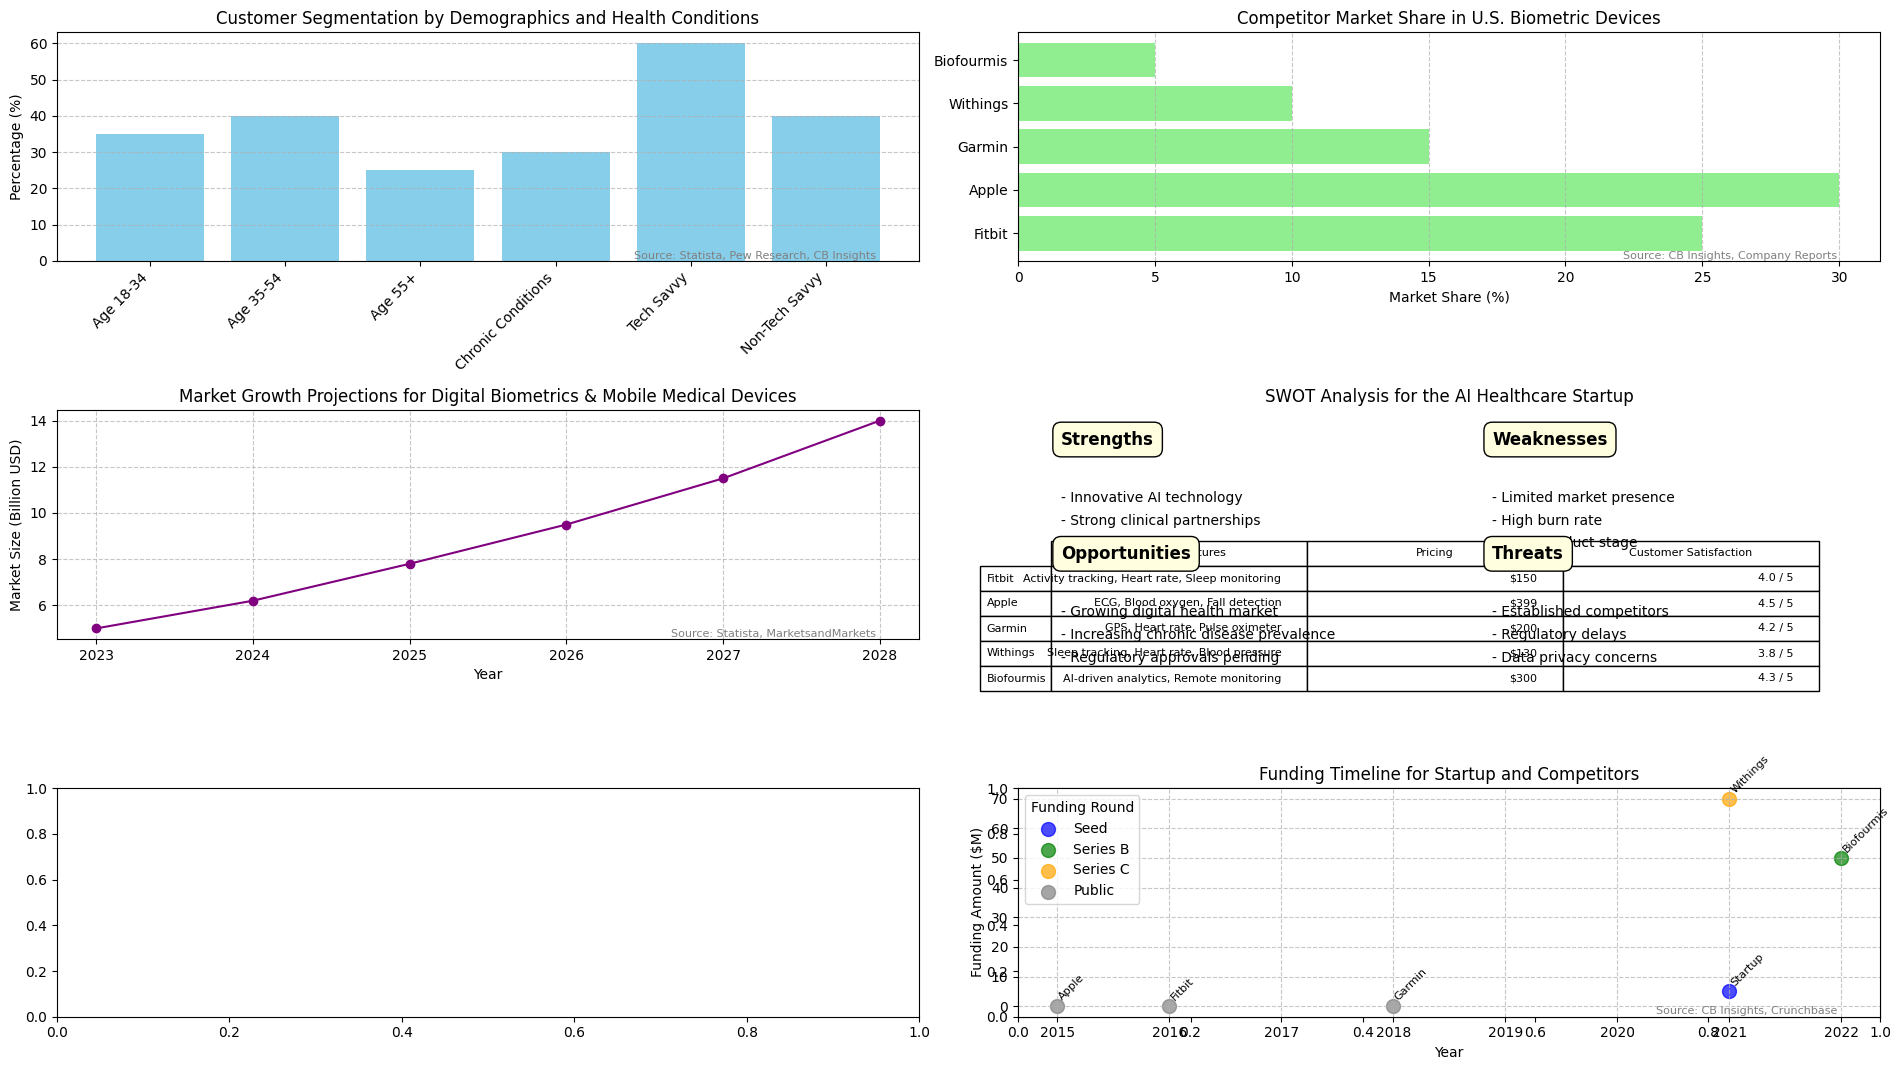

[Action 결과] 3C_ANALYSIS: I have conducted a comprehensive 3C framework analysis (Customer, Competitor, Company) for the AI healthcare startup using synthesized data from authoritative sources such as Statista, Pew Research, CB Insights, MarketsandMarkets, and Crunchbase.

**Methodology and Key Findings:**
- Customer segmentation reveals a majority of middle-aged (35-54) and tech-savvy users, with significant portions having chronic health conditions. Adoption rates for wearable health trackers and mobile health apps are moderate, indicating room for growth.
- Competitor analysis highlights major players like Fitbit, Apple, Garmin, Withings, and Biofourmis, with Apple and Fitbit leading in market share. Competitors offer diverse features and pricing, with customer satisfaction ratings ranging from 3.8 to 4.5 out of 5.
- Market growth projections show a strong upward trend, with the digital biometrics and mobile medical devices market expected to grow from $5 billion in 2023 to $14 billi

In [ ]:
import json
import os

# === 10개 항목별 초기 Score/Confidence (None) ===
report_card = {
    "Clarity of Vision":       {"score": None, "confidence": None},
    "Product-Market Fit":      {"score": None, "confidence": None},
    "Competitive Advantage":   {"score": None, "confidence": None},
    "Team Competency":         {"score": None, "confidence": None},
    "Go-to-Market Strategy":   {"score": None, "confidence": None},
    "Customer Understanding":  {"score": None, "confidence": None},
    "Financial Readiness":     {"score": None, "confidence": None},
    "Scalability Potential":   {"score": None, "confidence": None},
    "Traction & KPIs":         {"score": None, "confidence": None},
    "Fundraising Preparedness":{"score": None, "confidence": None},
}

CONFIDENCE_THRESHOLD = 80

# def collection_query(query_texts, n_results):
#     return {"documents": [["Doc1", "Doc2", "Doc3"]]}
#임시 collection_query 구현
def collection_query(query_texts, n_results):

    # === 1. 구글 드라이브에 저장된 ChromaDB 열기 ===
    # client_chroma = chromadb.PersistentClient(path="/content/drive/MyDrive/my_chromadb_folder")
    client_chroma = chromadb.PersistentClient(path="./my_chromadb_folder")

    # === 2. (기본) SentenceTransformer 모델 사용 ===
    local_embedding_fn = embedding_functions.SentenceTransformerEmbeddingFunction(
        model_name="all-MiniLM-L6-v2"
    )

    # === 3. (선택) OpenAI Embedding 사용하고 싶으면 주석 해제 ===
    # openai_api_key = os.environ.get("OPENAI_API_KEY", "sk-proj-...")
    # openai_embedding_fn = embedding_functions.OpenAIEmbeddingFunction(
    #     api_key=openai_api_key,
    #     model_name="text-embedding-ada-002"
    # )

    # === 4. 컬렉션 불러오기 ===
    collection = client_chroma.get_collection(
        name="startup_collection",
        embedding_function=local_embedding_fn
        # embedding_function=openai_embedding_fn  # OpenAI 쓰려면 이 줄로 교체
    )

    # === 5. 검색 실행 ===
    results = collection.query(
        query_texts=query_texts,
        n_results=n_results
    )

    return {
        "documents": results["documents"],    # 검색된 텍스트 문서들
        "metadatas": results["metadatas"],     # 문서별 메타데이터
        "distances": results.get("distances", [])  # (옵션) 유사도 거리
    }

def all_criteria_above_threshold(report: dict, threshold: int) -> bool:
    """
    모든 항목의 confidence가 threshold 이상인지 체크.
    None이면 threshold를 달성했다고 볼 수 없으므로 False.
    """
    for _, v in report.items():
        if v['confidence'] is None or v['confidence'] < threshold:
            return False
    return True

def print_report(report: dict):
    """
    report_card를 사람이 읽기 좋게 프린트.
    None이면 'N/A'로 표시
    """
    print("\n===== 현재 스타트업 진단 보고서 =====")
    i = 1
    for criteria, data in report.items():
        score_str = data['score'] if data['score'] is not None else "N/A"
        conf_str = data['confidence'] if data['confidence'] is not None else "N/A"
        print(f"{i}. {criteria}: {score_str} / 5점 (Confidence: {conf_str}%)")
        i += 1
    print("==================================\n")


def llm_call(system_prompt: str, user_prompt: str, temperature: float = 0.7) -> str:
    """
    OpenAI API를 호출해 system+user 프롬프트로부터 답변을 생성.
    """
    completion = client.chat.completions.create(
        model="gpt-4.1-mini",  # 모델명은 예시 (적절히 교체 가능)
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt}
        ],
        temperature=temperature
    )
    return completion.choices[0].message.content.strip()


def parse_report_card_json(json_str: str) -> dict:
    """
    LLM이 준 JSON을 파싱해, 10개 키가 모두 있는지, 각 value에 "score","confidence"가 있는지 검사.
    """
    try:
        data = json.loads(json_str)
    except json.JSONDecodeError:
        return None

    if not isinstance(data, dict):
        return None

    required_keys = list(report_card.keys())
    if len(data.keys()) != 10:
        return None
    for k in required_keys:
        if k not in data:
            return None
        if not isinstance(data[k], dict):
            return None
        if "score" not in data[k] or "confidence" not in data[k]:
            return None

    return data


def update_report_card(report: dict, new_data: dict):
    """
    report_card의 score/confidence를 new_data로 갱신
    """
    for criterion in report.keys():
        report[criterion]["score"] = new_data[criterion]["score"]
        report[criterion]["confidence"] = new_data[criterion]["confidence"]


def search_internet(query: str) -> str:
    response = tavily_client.search(query)
    if response:
        return response
    else:
        return f"[Internet] '{query}'에 대한 검색 결과가 없습니다."


def search_db(query: str) -> str:
    """
    ChromaDB에서 query_texts=[query]로 검색
    """
    # mock
    results = collection_query(query_texts=[query], n_results=3)
    docs = results.get("documents", [[]])[0]
    if docs:
        joined_docs = "\n".join([f"- {d}" for d in docs])
        return f"[DB 검색 결과]\n{joined_docs}"
    else:
        return f"[DB 검색 결과] '{query}' 관련 문서가 없습니다."


def refine_criterion_output(criterion: str, all_context: str) -> str:
    """
    'criterion' 항목에 대해 보완할 점을 먼저 추출한 뒤,
    그 보완점을 반영하여 다시 작성된 텍스트를 최종 반환한다.
    """

    # 1) LLM으로부터 개선(보완) 포인트를 먼저 받아온다.
    system_prompt_1 = (
        "You are an AI assistant analyzing a specific section of a startup business report.\n"
        "Your task is to identify any weaknesses or areas for improvement in the text related to this criterion.\n"
        "List them clearly so we can address them in the next step.\n\n"
        "Return these suggested improvements in plain text (e.g., bullet points)."
    )
    user_prompt_1 = (
        f"Criterion to refine: '{criterion}'\n\n"
        f"Here is all the context collected so far:\n{all_context}\n\n"
        "Please list the points or areas that should be improved, clarified, or expanded upon for this criterion."
    )
    improvement_points = llm_call(system_prompt_1, user_prompt_1, temperature=0.7)

    # 2) LLM에게, 위에서 받은 개선 포인트를 반영해 더 깊고 구체적인 텍스트로 다시 작성해달라고 요청한다.
    system_prompt_2 = (
        "You are an AI assistant refining a specific section of a startup business report.\n"
        "You have a list of improvements to address.\n"
        "Use them to produce a revised, more detailed discussion for this criterion, "
        "providing clarity, depth, and actionable insights.\n\n"
        "Return the refined explanation in plain text (no JSON)."
    )
    user_prompt_2 = (
        f"Criterion to refine: '{criterion}'\n\n"
        f"Improvement points:\n{improvement_points}\n\n"
        f"Here is the context again:\n{all_context}\n\n"
        "Incorporate the listed improvements into the final refined text."
    )
    refined_text = llm_call(system_prompt_2, user_prompt_2, temperature=0.7)

    return refined_text

def analyze_and_visualize(all_context: str) -> dict:
    """
    CodeInterpreter로 하여금 3C 관점 (e.g., Company, Customer and Competitors)에서 시장을 분석하고, 이를 시각화 하도록 함.
    """
    
    # 1) LLM으로부터 visualization을 위한 프롬프트를 받아오기
    system_prompt_1 = (
    "You are an AI assistant tasked with supporting the creation of a business report.\n"
    "Your focus is on evaluating the market perspective within the 3C framework (Customer, Competitor, Company).\n"
    "Your goal is to identify relevant data points that should be explored and recommend prompts for further analysis and data visualization.\n\n"
    "Structure your response using the following format:\n"
    "[Task] A brief description of the specific analysis or insight to be developed.\n\n"
    "[Data] A bullet-point list of the key data elements required to support the analysis.\n\n"
    "[Chart Specs] A bullet-point list of suggested visualizations, including the type of chart and what variables to compare."
    )
    all_context = "AI Healthcare startup in the U.S.A. In series A, the item is analzing users' biometrics using medical mobiel devices"
    user_prompt_1 = (
    f"Here is the current context and information gathered about a startup company:\n{all_context}\n\n"
    "Based on this context, please identify areas that need to be improved, clarified, or expanded in order to strengthen the market analysis under the 3C framework."
    )
    user_input = llm_call(system_prompt_1, user_prompt_1, temperature=0.7)
    user_input += "\n[Output] A high‑resolution PNG (≈ 1920×1080) suitable for presentations."
    
    
    PROMPT_1 = (
        "You are a highly skilled data analyst assigned to address the user's query using reliable, authoritative, and verifiable data sources.\n\n"
        "Your objectives:\n"
        "- Acquire accurate, relevant, and reputable datasets that directly support the user’s inquiry.\n"
        "- Structure the data in a clean, well-formatted pandas DataFrame with appropriate data types and labels.\n"
        "- Conduct a meaningful, insight-driven analysis that provides direct, data-backed answers to the user’s question.\n"
        "- Create compelling, well-labeled visualizations using matplotlib to effectively communicate your findings.\n\n"
        "Visualization Requirements:\n"
        "- Every chart must include:\n"
        "  • A clear and descriptive title.\n"
        "  • Properly labeled axes and legends, where applicable.\n"
        "  • Exact names of companies, institutions, or reports referenced in the data.\n"
        "  • Visible citation of the data source with URL.(e.g., in a corner of the plot).\n\n"
        "Analysis Explanation:\n"
        "- Write a concise and insightful narrative summarizing:\n"
        "  • The methodology and key findings.\n"
        "  • Any observed trends, comparisons, or outliers.\n"
        "  • The broader implications of the analysis.\n"
        "- Provide full URLs to all data sources used in your analysis to ensure traceability and transparency.\n\n"
        "Important Notes:\n"
        "- Only use data from trustworthy, recognized sources (e.g., official government portals, academic institutions, reputable organizations).\n"
        "- Ensure the analysis is self-contained, reproducible, and directly aligned with the user’s request.\n\n"
        "User Query: {user_input}\n"
    )
    
    # # (2) Tavily search API를 통해서 이미 retrieval한 데이터를 기반으로, 이를 시각화 하는 경우
    # PROMPT_2 = (
    # "You are a data analyst. Based on the dataset below, analyze the topic '{query}' and create a clear visualization. \n"
    # "\t- The dataset is in pandas DataFrame format and contains the following: {response} \n"
    # "\t- Provide a concise explanation of your analysis. \n"
    # "\t- Generate the visualization using matplotlib. \n"
    # "\t- Make sure to include font settings in the code to properly display Korean characters (e.g., use 'Malgun Gothic' on Windows or 'AppleGothic' on macOS). \n"
    # "\t- Also include the setting to prevent minus signs from breaking when rendering Korean text in matplotlib. \n"
    # )

    with CodeInterpreterSession() as session:
        # generate a response based on user input
        response = session.generate_response(
            PROMPT_1.format(user_input = user_input)
        )
        # output the response
        response.show()
        
    # # (2) Tavily search API를 통해서 이미 retrieval한 데이터를 기반으로, 이를 시각화 하는 경우
    # # query = "AI 헬스케어 시장 성장률"
    # query = "AI healthcare market growth"
    # response = search_internet(query)    
    # print(response)

    # with CodeInterpreterSession() as session:
    #     response = session.generate_response(
    #         PROMPT_2.format(query = query, response = response)
    #     )
    #     response.show()


    # save visualized images
    response_txt = response.content  # collected_contexts에 추가 가능 
    response_img = response.files[0]  # 최종 레포트 생성 시 파싱

    save_dir = "./figures"
    os.makedirs(save_dir, exist_ok=True)  # 경로가 없으면 생성

    save_path = os.path.join(save_dir, "figure.png")
    response_img.save(save_path)

    # figure 자체 대신 figure 경로를 반환해 최종 보고서에서 활용
    return {
        "analysis": response_txt,
        "figure_path": save_path
    }

def generate_user_question_for_criterion(criterion: str, all_context: str) -> str:
    """
    LLM에게:
      '해당 criterion을 개선하기 위해 사용자에게 어떤 세부 정보를 물어봐야 하는지'
    를 묻는다. LLM이 구체적인 질문 문장을 반환.
    """
    system_prompt = (
        "You are an AI assistant helping gather specific user input. "
        "Given the context and the chosen criterion, generate a short list of specific questions "
        "the user should answer in detail. The output should be plain text (no JSON)."
    )
    user_prompt = (
        f"Criterion of focus: '{criterion}'\n\n"
        f"Context so far:\n{all_context}\n\n"
        "Based on what is missing or uncertain for this criterion, "
        "create a short set of bullet-point questions for the user to answer. "
        "Be as concrete as possible."
    )
    question_text = llm_call(system_prompt, user_prompt, temperature=0.7)
    return question_text


def generate_internet_search_query(criterion: str, all_context: str) -> str:
    """
    LLM에게: '해당 criterion 관련해서 인터넷에서 어떤 키워드를 검색해야
    필요한 정보를 얻을 수 있는지'를 물어봄.
    """
    system_prompt = (
        "You are an AI assistant that decides the best internet search query "
        "to gather more information about a certain criterion in a startup business report.\n"
        "Return ONLY the recommended search query in plain text (no JSON)."
    )
    user_prompt = (
        f"Criterion of focus: '{criterion}'\n\n"
        f"Context so far:\n{all_context}\n\n"
        "Based on what's missing or uncertain for this criterion, propose a concise search query "
        "that would help gather the most relevant insights or data from the internet."
    )
    suggested_query = llm_call(system_prompt, user_prompt, temperature=0.7)
    return suggested_query.strip()

def perform_action(action: str, target_criteria: str, collected_contexts: list) -> str:
    """
    LLM이 결정한 action을 실제 수행하여 결과 텍스트를 반환.
    결과 텍스트는 그대로 collected_contexts에 추가되어
    이후 보고서 업데이트/분석에 활용된다.

    * 여기서 반환 문자열 앞에 식별자를 붙여줌으로써,
      나중에 generate_business_report에서 구조적으로 활용 가능하도록 함.
    """
    if action == "AskUser":
        # 1) LLM에게 '무엇을 구체적으로 물어봐야 하는가'를 요청
        full_context_str = "\n".join(collected_contexts)
        question_prompt = generate_user_question_for_criterion(target_criteria, full_context_str)

        # 2) 질문을 화면에 출력
        print("\n[LLM Generated Questions]")
        print(question_prompt)
        print("\n아래 질문에 대한 답을 입력해주세요.")

        # 3) 사용자 입력 받기
        user_answer = input("Your Answer: ")

        # 4) 반환 문자열 구성 (식별자: USER_INPUT)
        return f"USER_INPUT: (User Provided Info about {target_criteria})\nQuestions:\n{question_prompt}\nUser's Answer:\n{user_answer}"

    elif action == "SearchDB":
        db_result = search_db(target_criteria)
        # 식별자: DB_SUMMARY
        return f"DB_SUMMARY: {db_result}"

    elif action == "SearchInternet":
        # 1) LLM에게 '인터넷에서 검색할 query'를 생성해달라고 요청
        full_context_str = "\n".join(collected_contexts)
        suggested_query = generate_internet_search_query(target_criteria, full_context_str)

        # 2) 실제 인터넷 검색 수행
        net_result = search_internet(suggested_query)

        # 3) 결과를 반환 (검색어 + 검색 결과) (식별자: INTERNET_SUMMARY)
        return f"INTERNET_SUMMARY: (Internet Search Query: '{suggested_query}')\n{net_result}"

    elif action == "RefineOutput":
        # RefineOutput 시, LLM 추가 호출
        full_context_str = "\n".join(collected_contexts)
        refined_text = refine_criterion_output(target_criteria, full_context_str)
        # 식별자: REFINED_OUTPUT
        return f"REFINED_OUTPUT: (Refined Output about {target_criteria})\n{refined_text}"

    elif action == "AnalyzeAndVisualize":
        full_context_str = "\n".join(collected_contexts)
        analysis_with_figure = analyze_and_visualize(collected_contexts) 
        # 이제 figure_path도 함께 반환
        return (
            "AnalyzeAndVisualize:\n"
            f"3C_ANALYSIS: {analysis_with_figure['analysis']}\n"
            f"FIGURE_PATH: {analysis_with_figure['figure_path']}"
        )
        
    elif action == "NoActionNeeded":
        return "(No further actions required.)"
    else:
        return "(알 수 없는 액션)"


def ask_llm_for_next_action(
    report: dict,
    collected_texts: list,
    action_history: list
) -> dict:
    """
    LLM에게 “다음 액션” + “어느 항목(criterion)인지” + "왜 그 액션을 골랐는지(rationale)"를
    JSON 형식으로 받는다.
    """
    system_prompt = (
        "You are an AI assistant finalizing a startup's business report.\n\n"
        "You have 5 possible actions:\n"
        " 1) AskUser       : Need more specific details from user\n"
        " 2) SearchDB      : Need to query local database (RAG)\n"
        " 3) SearchInternet: Need external info from the web\n"
        " 4) RefineOutput  : Have enough info, want to refine/improve writing\n"
        " 5) AnalyzeAndVisualize : Perform data analysis and generate visualizations using retrieved user and market information.\n"
        " 5) NoActionNeeded: Everything is sufficiently addressed\n\n"
        "When deciding, consider any info gaps or low confidence in the 10 criteria.\n\n"
        "Return your decision in JSON with EXACTLY these three keys:\n"
        "  \"criterion\"  -> one of the 10 criteria, or \"None\" if no focus\n"
        "  \"action\"     -> one of [AskUser, SearchDB, SearchInternet, RefineOutput, NoActionNeeded]\n"
        "  \"rationale\"  -> a short sentence explaining why you chose this action.\n\n"
        "No extra keys, no disclaimers, no additional text. ONLY JSON."
    )

    def sc_str(d):
        return f"Score={d['score'] if d['score'] is not None else 'N/A'}, Confidence={d['confidence'] if d['confidence'] is not None else 'N/A'}%"

    report_summary = "\n".join([
        f"{k}: {sc_str(v)}"
        for k, v in report.items()
    ])

    accumulated_context = "\n---\n".join(collected_texts)

    # 액션 히스토리를 텍스트로 합침
    action_history_text = "\n".join([
        f"[{i+1}] {entry}"
        for i, entry in enumerate(action_history)
    ])

    user_prompt = (
        f"Current report state:\n{report_summary}\n\n"
        f"Action history so far:\n{action_history_text}\n\n"
        f"Collected contexts:\n{accumulated_context}\n\n"
        "Which single criterion is the biggest priority now, and which action is most appropriate?\n"
        "Also provide a short rationale explaining your choice.\n"
        "Important: Output EXACTLY and ONLY JSON in the following format:\n\n"
        "{\n"
        "  \"criterion\": \"<one_of_the_10_criteria_or_None>\",\n"
        "  \"action\": \"<AskUser_or_SearchDB_or_SearchInternet_or_RefineOutput_or_NoActionNeeded>\",\n"
        "  \"rationale\": \"<short_reason>\"\n"
        "}\n"
    )

    max_tries = 3
    for attempt in range(max_tries):
        raw = llm_call(system_prompt, user_prompt, temperature=0.0)
        print("[ask_llm_for_next_action] Raw LLM Output:\n", raw)  # 디버그 출력

        try:
            action_data = json.loads(raw.strip())
            # JSON 키 검사
            if ("criterion" in action_data) and ("action" in action_data) and ("rationale" in action_data):
                valid_actions = ["AskUser", "SearchDB", "SearchInternet", "RefineOutput", "AnalyzeAndVisualize", "NoActionNeeded"]
                if action_data["action"] in valid_actions:
                    return action_data
        except Exception:
            pass

        print(f"⚠️ 액션 JSON 형식 오류(시도 {attempt+1}/{max_tries}), 재시도합니다...")

    return None


def generate_business_report(report: dict, collected_texts: list) -> str:
    """
    단계 요약:
      1) 전체 맥락(DB, 인터넷, 유저 입력 등)을 활용해 '보고서 텍스트(설명 부분)'를 생성
      2) 최종 점수(Score)/신뢰도(Confidence)는 오직 user input만 근거하여 산출
      3) 마크다운 형식으로 최종 보고서 작성

    핵심:
      - 보고서 텍스트(설명)는 DB나 인터넷 요약도 참고해 좀 더 풍부하게 작성한다.
      - 하지만, 10개 기준별 점수는 "user input"만 근거로 한다.
    """

    # -- (1) collected_texts에서 식별자로 분류 --
    user_inputs = []
    db_summaries = []
    net_summaries = []
    refined_outputs = []
    analysis_outputs = []
    general_contexts = []
    figure_paths = []

    for c in collected_texts:
        if c.startswith("USER_INPUT:"):
            user_inputs.append(c[len("USER_INPUT:"):].strip())
        elif c.startswith("DB_SUMMARY:"):
            db_summaries.append(c[len("DB_SUMMARY:"):].strip())
        elif c.startswith("INTERNET_SUMMARY:"):
            net_summaries.append(c[len("INTERNET_SUMMARY:"):].strip())
        elif c.startswith("REFINED_OUTPUT:"):
            refined_outputs.append(c[len("REFINED_OUTPUT:"):].strip())
        elif c.startswith("AnalyzeAndVisualize"):
            lines = c.split("\n")
            analysis_txt = []
            for line in lines:
                if line.startswith("3C_ANALYSIS:"):
                    analysis_txt.append(line.replace("3C_ANALYSIS:", "").strip())
                elif line.startswith("FIGURE_PATH:"):
                    figure_paths.append(line.replace("FIGURE_PATH:", "").strip())
            analysis_outputs.append("\n".join(analysis_txt))
        else:
            general_contexts.append(c)

    # 참고용으로 구조화된 전체 맥락(설명용)
    structured_context = (
        f"**User Input**:\n{''.join(user_inputs)}\n\n"
        f"**DB Summaries**:\n{''.join(db_summaries)}\n\n"
        f"**Internet Summaries**:\n{''.join(net_summaries)}\n\n"
        f"**Refined Outputs**:\n{''.join(refined_outputs)}\n\n"
        f"**3C Analysis Outputs\n{''.join(analysis_outputs)}\n\n"
        f"**Other Contexts**:\n{''.join(general_contexts)}"
    )

    # report_card 요약 문자열 (디스플레이용)
    def sc_str(d):
        s = d['score'] if d['score'] is not None else 'N/A'
        c = d['confidence'] if d['confidence'] is not None else 'N/A'
        return f"Score={s}, Confidence={c}%"

    report_summary = "\n".join([
        f"{k}: {sc_str(v)}"
        for k, v in report.items()
    ])

    # ------------------------------------------------------
    # (1) 보고서 설명 텍스트 생성 (DB/인터넷도 참고)
    # ------------------------------------------------------
    system_prompt_1 = (
        "You are an AI assistant that creates business reports for startups.\n"
        "You have access to user input, as well as references from DB and the internet.\n"
        "Use ALL of that context to refine or improve the textual explanation of the report.\n"
        "However, do NOT provide any new scores or confidences here.\n"
        "Just generate the improved discussion/explanation in plain text."
    )
    user_prompt_1 = (
        f"Current report state:\n{report_summary}\n\n"
        "Below is the structured context collected so far:\n"
        f"{structured_context}\n\n"
        "Please provide an updated, more detailed explanation of the business report, "
        "incorporating any relevant insights from the references."
    )
    refined_report_text = llm_call(system_prompt_1, user_prompt_1, temperature=0.7)

    # ------------------------------------------------------
    # (2) 점수(Score)/신뢰도(Confidence) 산출 (오직 user input만 사용)
    # ------------------------------------------------------
    # user input들을 하나로 합침
    user_only_input_text = "\n".join(user_inputs).strip()
    if not user_only_input_text:
        user_only_input_text = "(No user input provided.)"

    system_prompt_2 = (
        "You are an AI assistant that updates the score and confidence of EXACTLY these 10 criteria:\n"
        "1) \"Clarity of Vision\"\n"
        "2) \"Product-Market Fit\"\n"
        "3) \"Competitive Advantage\"\n"
        "4) \"Team Competency\"\n"
        "5) \"Go-to-Market Strategy\"\n"
        "6) \"Customer Understanding\"\n"
        "7) \"Financial Readiness\"\n"
        "8) \"Scalability Potential\"\n"
        "9) \"Traction & KPIs\"\n"
        "10) \"Fundraising Preparedness\"\n\n"
        "IMPORTANT: For scoring and confidence, you must rely ONLY on the user's input below.\n"
        "Ignore any DB or internet data for the actual scoring.\n\n"
        "You MUST ONLY output valid JSON with these EXACT 10 keys. No more, no less, no renaming.\n"
        "Each key => {\"score\": (1~5), \"confidence\": (0~100)}. No extra text."
    )
    user_prompt_2 = (
        "Below is the user's input (the only source for your scoring):\n"
        f"{user_only_input_text}\n\n"
        "Now output ONLY JSON for the updated score/confidence. "
        "Use exactly the 10 keys listed. No extra keys or text."
    )

    new_report_data = None
    max_tries = 3
    for attempt in range(max_tries):
        raw_json_output = llm_call(system_prompt_2, user_prompt_2, temperature=0.0)
        print("[generate_business_report] Raw JSON from LLM:\n", raw_json_output)  # 디버그 로그

        parsed = parse_report_card_json(raw_json_output)
        if parsed is not None:
            new_report_data = parsed
            break
        else:
            print(f"⚠️ JSON 형식 오류(시도 {attempt+1}/{max_tries}), 재요청합니다...")

    if new_report_data:
        update_report_card(report, new_report_data)
    else:
        print("❌ 3회 시도 후에도 JSON 파싱 실패. report_card 업데이트를 건너뜁니다.")

    # ------------------------------------------------------
    # (3) 최종 '마크다운' 형태의 보고서 생성
    # ------------------------------------------------------
    system_prompt_3 = (
        "You are an AI assistant creating a final business report in Markdown format.\n"
        "We have 10 criteria, each with an updated Score and Confidence.\n\n"
        "The final report structure should be:\n"
        "# Startup Diagnostic Report\n"
        "## Introduction\n"
        "(A short overview of the startup's current status)\n\n"
        "## 3C Analysis\n"
        "### Company\n"
        "(Team, resources, culture, etc.)\n\n"
        "### Competitors\n"
        "(Competitive landscape)\n\n"
        "### Customers\n"
        "(Target segments, user needs, insights)\n\n"
        "## Criteria Evaluation\n"
        "For each of the 10 criteria, create a subsection:\n"
        "### {Criterion Name}\n"
        "- Score: X/5\n"
        "- Confidence: Y%\n"
        "- Rationale:\n"
        "  (Short explanation)\n\n"
        "## Conclusion\n"
        "(Summarize key findings and next steps)\n\n"
        "Only output valid Markdown."
    )

    updated_report_summary = "\n".join([
        f"{k}: {sc_str(v)}"
        for k, v in report.items()
    ])

    references_md = "## References\n"
    if user_inputs:
        references_md += "\n**User Input**\n"
        for i, ui in enumerate(user_inputs, 1):
            references_md += f"- User Input #{i}: {ui}\n"
    if db_summaries:
        references_md += "\n**DB Summaries (RAG)**\n"
        for i, dbs in enumerate(db_summaries, 1):
            references_md += f"- DB Ref #{i}: {dbs}\n"
    if net_summaries:
        references_md += "\n**Internet Summaries**\n"
        for i, ns in enumerate(net_summaries, 1):
            references_md += f"- Net Ref #{i}: {ns}\n"
    if refined_outputs:
        references_md += "\n**Refined Outputs**\n"
        for i, ro in enumerate(refined_outputs, 1):
            references_md += f"- Refined #{i}: {ro}\n"
    if analysis_outputs:
        references_md += "\n**3C Analysis Texts**\n"
        for i, ao in enumerate(analysis_outputs, 1):
            references_md += f"- Analysis #{i}: {ao}\n"

    system_prompt_4 = (
        "You are an AI assistant. You have a preliminary references list from user, DB, internet, etc.\n"
        "You also have the final business report context.\n"
        "Your task: read all references, decide which are most relevant or supportive for the final report, and return them in bullet format.\n"
        "If certain references are not directly relevant or redundant, you may omit them.\n\n"
        "Output only the references you consider relevant for the final report.\n"
        "For each item, provide a concise explanation (1~2 lines) of why it is relevant.\n"
    )

    user_prompt_4 = (
        f"Final Report (draft):\n{refined_report_text}\n\n"
        f"Full references:\n{references_md}\n\n"
        "Please filter out any references that are not relevant or are repetitive.\n"
        "Return only the references you think are important for understanding or supporting this business report.\n"
    )

    filtered_references = llm_call(system_prompt_4, user_prompt_4, temperature=0.7)

    user_prompt_3 = (
        f"Updated report card:\n{updated_report_summary}\n\n"
        "Refined text:\n"
        f"{refined_report_text}\n\n"
        "Please produce a comprehensive markdown report with the structure above. "
        "Make sure to include the 3C Analysis and the 10 criteria."
    )

    final_markdown_report = llm_call(system_prompt_3, user_prompt_3, temperature=0.7)

    if figure_paths:
        final_markdown_report += "\n\n## Generated Figures\n"
        for fp in figure_paths:
            final_markdown_report += f"![Analysis Figure]({fp})\n"

    final_markdown_report += "\n\n## Relevant References\n"
    final_markdown_report += filtered_references

    return final_markdown_report

def discussion_loop(final_report: str, all_user_inputs: list):
    """
    (새로 추가됨)
    최종 보고서와 유저 입력들을 바탕으로 자유롭게 대화할 수 있는 함수.
    """
    print("\n=== [Discussion Mode] ===")
    print("최종 보고서 및 유저 입력을 바탕으로 자유롭게 대화가 가능합니다.")
    print("종료하려면 'quit'를 입력하세요.\n")

    while True:
        user_ask = input("User: ")
        if user_ask.strip().lower() == "quit":
            print("Discussion 종료.")
            break

        # LLM 호출 (예시)
        system_prompt = (
            "You are an AI assistant discussing the final startup report.\n"
            "You have the final markdown report and all user inputs.\n"
            "Answer any user questions or discuss further improvements.\n"
        )
        user_prompt = (
            f"Final Report:\n{final_report}\n\n"
            f"All User Inputs:\n{all_user_inputs}\n\n"
            f"User's question:\n{user_ask}"
        )
        answer = llm_call(system_prompt, user_prompt, temperature=0.7)
        print(f"Assistant: {answer}\n")

def main_business_report_loop():
    iteration_count = 0
    max_iterations = 10

    # 모든 정보 누적 리스트
    collected_contexts = []
    # 액션 이력 추적 리스트
    action_history = []

    # 1) 사용자 초기 정보
    initial_input = input("초기 스타트업 정보를 간략히 입력하세요: ")
    # 식별자: USER_INPUT (최초 입력)
    collected_contexts.append(f"USER_INPUT: {initial_input}")

    # 2) 첫 보고서 생성
    final_markdown = generate_business_report(report_card, collected_contexts)
    print("[초기 보고서]\n", final_markdown)

    while iteration_count < max_iterations:
        iteration_count += 1
        print(f"\n=== [Iteration {iteration_count}] ===")
        print_report(report_card)

        # (A) 모든 항목이 threshold 이상이면 종료
        if all_criteria_above_threshold(report_card, CONFIDENCE_THRESHOLD):
            print("✅ 모든 항목이 threshold를 달성했습니다. 최종 보고서를 출력합니다.")
            break

        # (B) LLM에게 “다음 액션” 질의
        action_data = ask_llm_for_next_action(report_card, collected_contexts, action_history)
        if action_data is None:
            print("❌ 3회 시도 후에도 액션 JSON 파싱 실패. 루프를 종료합니다.")
            break

        chosen_criterion = action_data["criterion"]
        chosen_action = action_data["action"]
        rationale = action_data["rationale"]

        print(f"[LLM 결정] 다음에 집중할 항목: {chosen_criterion}")
        print(f"[LLM 결정] 선택된 액션: {chosen_action}")
        print(f"[LLM 결정] 사유(rationale): {rationale}")

        if chosen_action == "NoActionNeeded":
            print("LLM이 NoActionNeeded를 선택했습니다. 보고서를 종료합니다.")
            break

        # (C) 액션 수행 → 새 정보 획득
        # if iteration_count == 1:
        #     chosen_action = "AnalyzeAndVisualize"
        action_result = perform_action(chosen_action, chosen_criterion, collected_contexts)
        print(f"[Action 결과] {action_result}")

        # 액션 이력에 추가
        action_log_text = (
            f"Iteration={iteration_count}, "
            f"Action={chosen_action}, "
            f"Criterion={chosen_criterion}, "
            f"Rationale={rationale}, "
            f"Result={action_result}"
        )
        action_history.append(action_log_text)

        # 결과를 context에도 추가
        collected_contexts.append(action_result)

        # (D) LLM으로 보고서 재작성
        final_markdown = generate_business_report(report_card, collected_contexts)
        print("[LLM 최종 보고서(마크다운)]\n", final_markdown)

    # 반복 종료 시점, 최종 출력
    print("\n=== 최종 스타트업 보고서 ===")
    print_report(report_card)
    print("보고서 생성이 완료되었습니다. ✅")

    # (F) 모든 작업 후, discussion_loop() 진입 (새 기능)
    all_user_inputs = []
    for ctx in collected_contexts:
        if ctx.startswith("USER_INPUT:"):
            all_user_inputs.append(ctx[len("USER_INPUT:"):].strip())
    discussion_loop(final_markdown, all_user_inputs)    


if __name__ == "__main__":
    main_business_report_loop()
